In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [143]:
oil_df = pd.read_csv("oil.csv")
oil_df

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [144]:
oil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [145]:
oil_df.describe
oil_df['date'].unique()

oil_df['date'] = pd.to_datetime(oil_df['date'])
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].interpolate(method='linear')
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')

C:\Users\elisa\AppData\Local\Temp\ipykernel_11836\909694326.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  oil_df['dcoilwtico'] = oil_df['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')


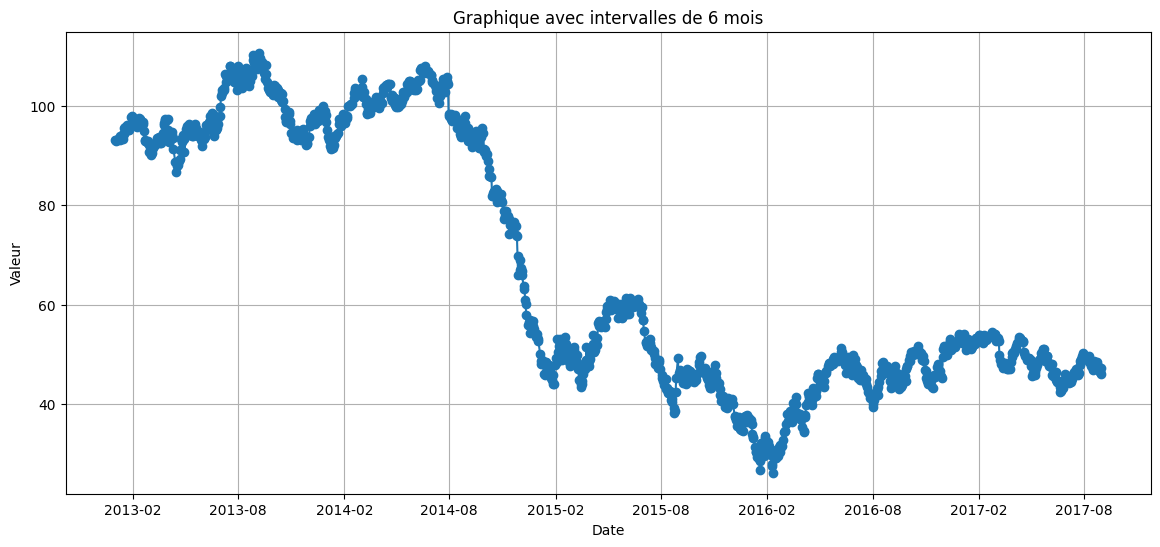

In [146]:
plt.figure(figsize=(14, 6))
plt.plot(oil_df['date'], oil_df['dcoilwtico'], marker='o')

# Configuration des intervalles de 6 mois
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xlabel('Date')
plt.ylabel('Valeur')
plt.title('Graphique avec intervalles de 6 mois')
plt.grid(True)

plt.show()

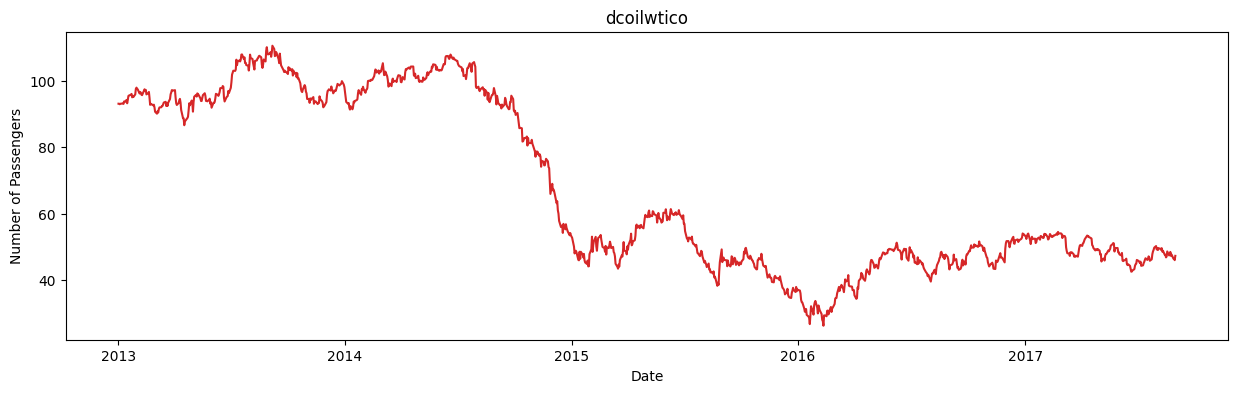

In [147]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Number of Passengers', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    
plot_df(oil_df, x=oil_df['date'], y=oil_df['dcoilwtico'], title='dcoilwtico')

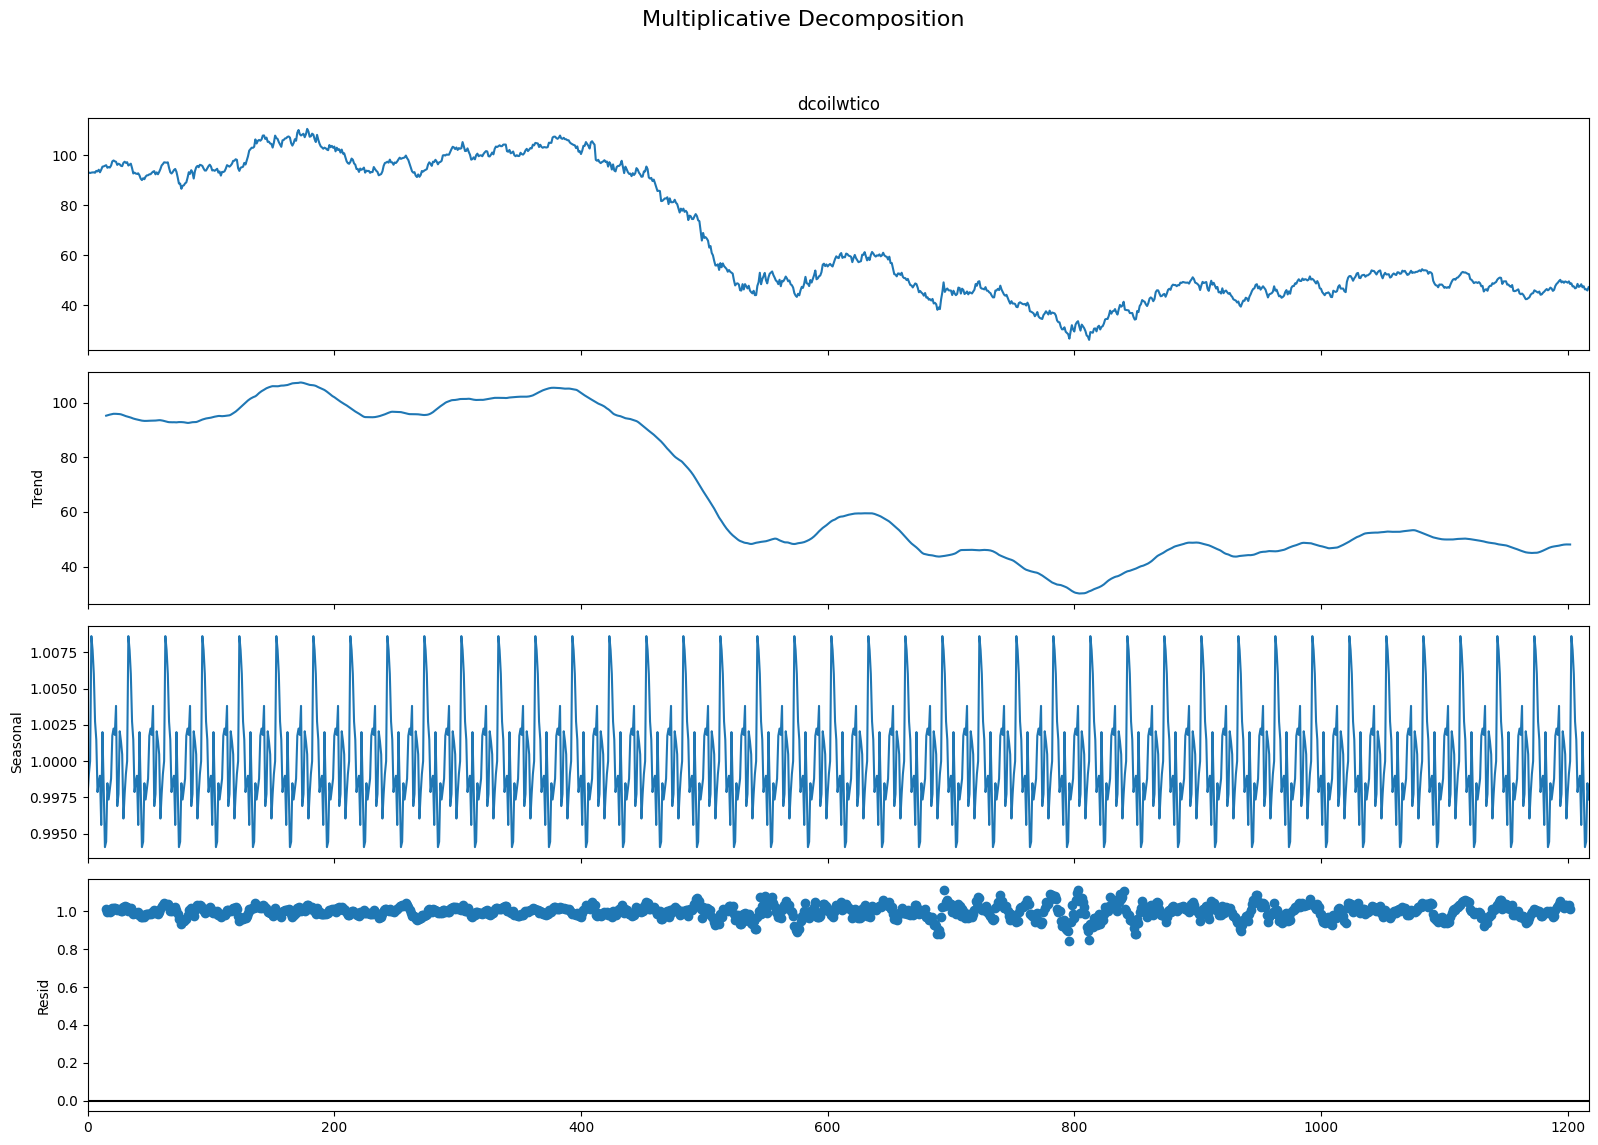

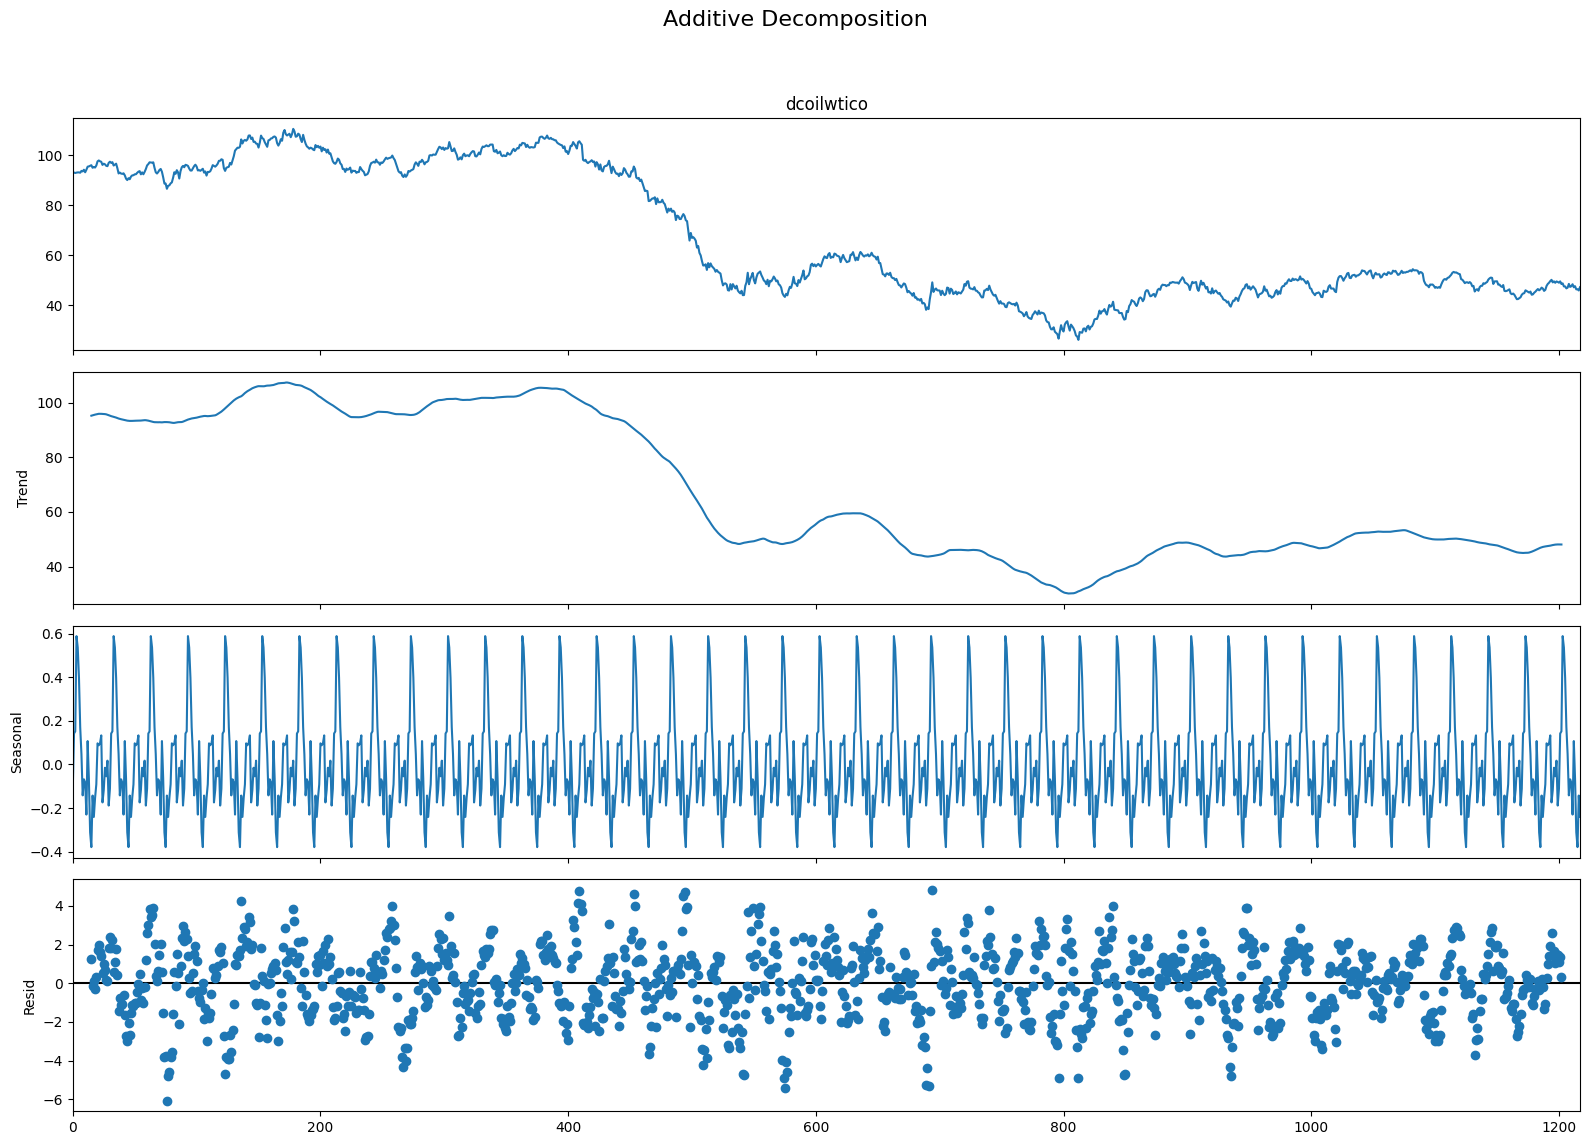

In [148]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

multiplicative_decomposition = seasonal_decompose(oil_df['dcoilwtico'], model='multiplicative', period=30)

additive_decomposition = seasonal_decompose(oil_df['dcoilwtico'], model='additive', period=30)

plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

**Modèle Additif :** Si les variations saisonnières sont constantes et les résidus sont indépendants.

**Modèle Multiplicatif :** Si les variations saisonnières sont proportionnelles au niveau de la série -> try la log-transformation. Si la décomposition additive des données log-transformées fonctionne bien, cela indique un modèle multiplicatif.

-> Modèle Additif car les résidus semblent aléatoire et sans structure apparente

In [149]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

In [150]:
oil_df['log_dcoilwtico'] = np.log(oil_df['dcoilwtico'])

In [151]:
decomposition = seasonal_decompose(oil_df['log_dcoilwtico'], model='additive', period=30)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [152]:
result = adfuller(residual.dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -9.733938748267626
p-value: 8.852651864008073e-17


In [153]:
if result[1] < 0.05:
    # Ajustement d'un modèle AR aux résidus
    model = AutoReg(residual.dropna(), lags=1)
    model_fit = model.fit()
    print(model_fit.summary())

    # Utilisation du modèle pour la prévision des résidus
    residual_forecast = model_fit.predict(start=len(residual), end=len(residual)+30)
    print(residual_forecast)
else:
    print("Les résidus ne sont pas stationnaires, essayez d'autres transformations.")

                            AutoReg Model Results                             
Dep. Variable:                  resid   No. Observations:                 1188
Model:                     AutoReg(1)   Log Likelihood                2940.948
Method:               Conditional MLE   S.D. of innovations              0.020
Date:                Sat, 15 Jun 2024   AIC                          -5875.895
Time:                        14:34:23   BIC                          -5860.658
Sample:                             1   HQIC                         -5870.152
                                 1188                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.112e-05      0.001      0.053      0.958      -0.001       0.001
resid.L1       0.7917      0.018     44.653      0.000       0.757       0.826
                                    Roots           

C:\Users\elisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\elisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\elisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


AR(1)

In [154]:
# AR(1)
model = AutoReg(residual.dropna(), lags=1)
model_fit = model.fit()
print(model_fit.summary())

# Utilisation du modèle pour la prévision des résidus
residual_forecast = model_fit.predict(start=len(residual), end=len(residual)+30)
print(residual_forecast)

                            AutoReg Model Results                             
Dep. Variable:                  resid   No. Observations:                 1188
Model:                     AutoReg(1)   Log Likelihood                2940.948
Method:               Conditional MLE   S.D. of innovations              0.020
Date:                Sat, 15 Jun 2024   AIC                          -5875.895
Time:                        14:34:23   BIC                          -5860.658
Sample:                             1   HQIC                         -5870.152
                                 1188                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.112e-05      0.001      0.053      0.958      -0.001       0.001
resid.L1       0.7917      0.018     44.653      0.000       0.757       0.826
                                    Roots           

C:\Users\elisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\elisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\elisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [155]:
oil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            1218 non-null   datetime64[ns]
 1   dcoilwtico      1218 non-null   float64       
 2   log_dcoilwtico  1218 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 28.7 KB


ARIMA(1,1,1)

In [156]:
# Création et ajustement du modèle ARIMA
# (p, d, q) : (1, 1, 1) est un exemple, vous devez choisir les valeurs appropriées pour vos données
model = ARIMA(oil_df['log_dcoilwtico'], order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

# Utilisation du modèle pour la prévision
# Prévisions sur 30 périodes
forecast = model_fit.forecast(steps=30)
print(forecast)

                               SARIMAX Results                                
Dep. Variable:         log_dcoilwtico   No. Observations:                 1218
Model:                 ARIMA(1, 1, 1)   Log Likelihood                2924.835
Date:                Sat, 15 Jun 2024   AIC                          -5843.671
Time:                        14:34:23   BIC                          -5828.358
Sample:                             0   HQIC                         -5837.907
                               - 1218                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2306      0.506      0.456      0.649      -0.761       1.223
ma.L1         -0.2684      0.499     -0.538      0.590      -1.246       0.709
sigma2         0.0005   1.29e-05     37.069      0.0

C:\Users\elisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\elisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\elisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:         log_dcoilwtico   No. Observations:                 1218
Model:                 ARIMA(1, 1, 1)   Log Likelihood                2924.835
Date:                Sat, 15 Jun 2024   AIC                          -5843.671
Time:                        14:34:23   BIC                          -5828.358
Sample:                    01-01-2013   HQIC                         -5837.907
                         - 08-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2306      0.506      0.456      0.649      -0.761       1.223
ma.L1         -0.2684      0.499     -0.538      0.590      -1.246       0.709
sigma2         0.0005   1.29e-05     37.069      0.0

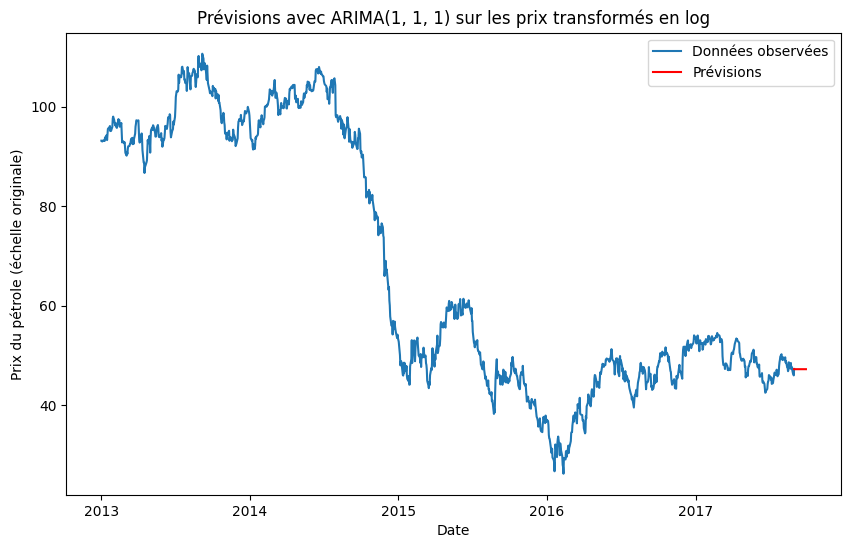

In [158]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Création et ajustement du modèle ARIMA
model = ARIMA(oil_df['log_dcoilwtico'], order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

# Utilisation du modèle pour la prévision
# Prévisions sur 30 périodes
forecast_log = model_fit.forecast(steps=30)
forecast = np.exp(forecast_log)  # Convertir les prévisions en échelle d'origine
print(forecast)

# Création d'un nouvel index pour les prévisions
last_date = oil_df.index[-1]
forecast_index = pd.date_range(start=last_date, periods=30, freq='D')

# Optionnel: Visualisation des données et des prévisions
plt.figure(figsize=(10, 6))
plt.plot(oil_df.index, np.exp(oil_df['log_dcoilwtico']), label='Données observées')
plt.plot(forecast_index, forecast, label='Prévisions', color='red')
plt.legend()
plt.title('Prévisions avec ARIMA(1, 1, 1) sur les prix transformés en log')
plt.xlabel('Date')
plt.ylabel('Prix du pétrole (échelle originale)')
plt.show()

Recherche des paramètres optimaux p, q, d

In [159]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import warnings

ADF Statistic: -0.9103326459313698
p-value: 0.7845506871066799


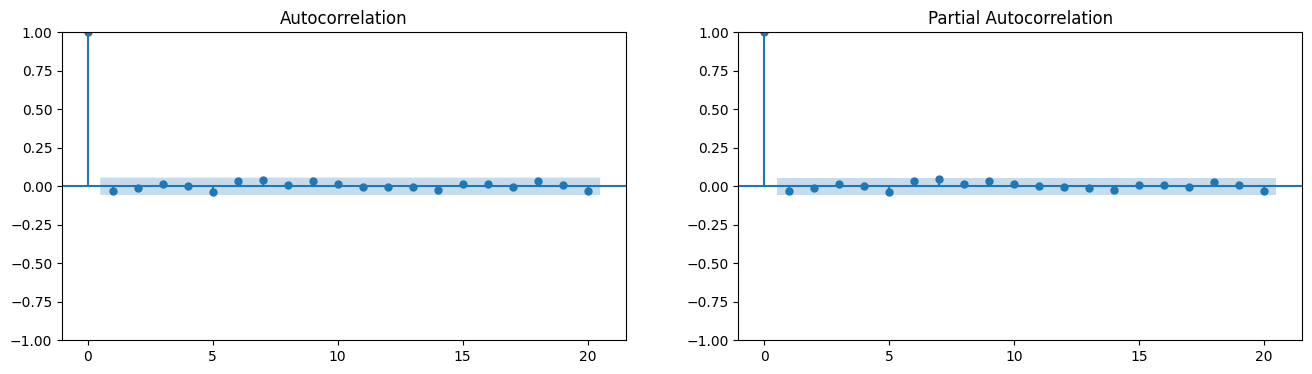

C:\Users\elisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\elisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\elisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\elisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCac

Meilleurs paramètres ARIMA: (2, 1, 2)
                               SARIMAX Results                                
Dep. Variable:             dcoilwtico   No. Observations:                 1218
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1919.109
Date:                Sat, 15 Jun 2024   AIC                           3848.218
Time:                        14:39:10   BIC                           3873.739
Sample:                    01-01-2013   HQIC                          3857.825
                         - 08-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0179      0.009     -2.009      0.044      -0.035      -0.000
ar.L2         -0.9813      0.009   -110.156      0.000      -0.999      -0.964
ma.L1         

C:\Users\elisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


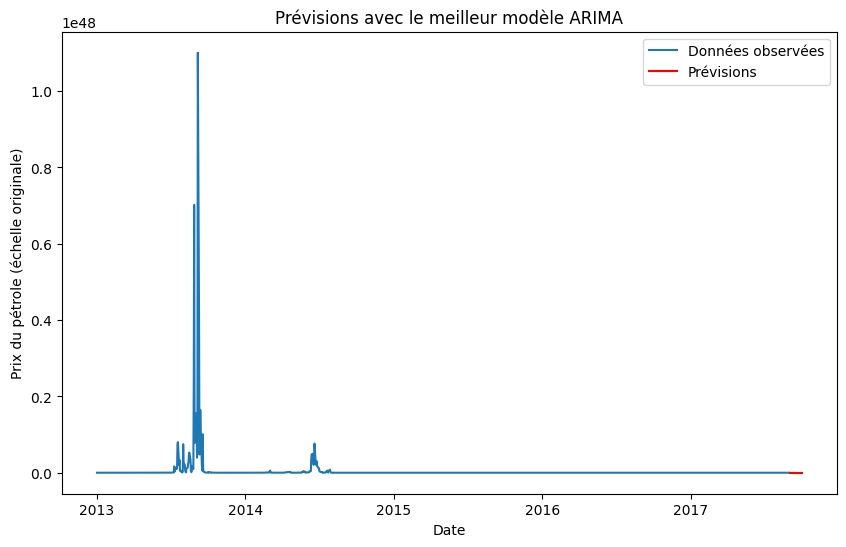

In [161]:
result = adfuller(oil_df['dcoilwtico'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Si la série n'est pas stationnaire, effectuez la différenciation
oil_df['diff_dcoilwtico'] = oil_df['dcoilwtico'].diff().dropna()

# Plots ACF et PACF pour déterminer p et q
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(oil_df['diff_dcoilwtico'].dropna(), lags=20, ax=axes[0])
plot_pacf(oil_df['diff_dcoilwtico'].dropna(), lags=20, ax=axes[1])
plt.show()

# Recherche par grille pour les meilleurs paramètres p, d, q
import itertools

p = range(0, 3)
d = range(0, 2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))

aic_values = []
parameters = []

for param in pdq:
    try:
        model = ARIMA(oil_df['dcoilwtico'], order=param)
        model_fit = model.fit()
        aic_values.append(model_fit.aic)
        parameters.append(param)
    except:
        continue

best_aic_index = aic_values.index(min(aic_values))
best_params = parameters[best_aic_index]

print('Meilleurs paramètres ARIMA:', best_params)

# Ajustement du meilleur modèle ARIMA
best_model = ARIMA(oil_df['dcoilwtico'], order=best_params)
best_model_fit = best_model.fit()
print(best_model_fit.summary())

# Prévisions avec le meilleur modèle
forecast_log = best_model_fit.forecast(steps=30)
forecast = np.exp(forecast_log)
print(forecast)

# Visualisation
last_date = oil_df.index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

plt.figure(figsize=(10, 6))
plt.plot(oil_df.index, np.exp(oil_df['dcoilwtico']), label='Données observées')
plt.plot(forecast_index, forecast, label='Prévisions', color='red')
plt.legend()
plt.title('Prévisions avec le meilleur modèle ARIMA')
plt.xlabel('Date')
plt.ylabel('Prix du pétrole (échelle originale)')
plt.show()